In [15]:
import logging

import torch
import torch.optim as optim

from robustbench.data import load_cifar10c, load_cifar10
from robustbench.model_zoo.enums import ThreatModel
from robustbench.utils import load_model
from nets import *

import time
import tent
import norm
import oracle
from utils import *
from matplotlib import pyplot as plt


import ipdb

from conf import cfg, load_cfg_fom_args, merge_from_file

corruption_list = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness',
                        'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']


In [16]:
logger = logging.getLogger(__name__)
merge_from_file('cfgs/multistage.yaml')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(cfg)
print(device)

BN:
  EPS: 1e-05
  MOM: 0.1
CKPT_DIR: ./ckpt
CORRUPTION:
  DATASET: cifar10
  NUM_EX: 10000
  SEVERITY: [5]
  TYPE: ['gaussian_noise']
CUDNN:
  BENCHMARK: True
DATA_DIR: /gallery_tate/wonjae.roh
DESC: 
EPOCH: 50
EXPERIMENTAL:
  LINEAR_RETRAIN: False
ITERATION: 1
LOG_DEST: log.txt
LOG_TIME: 
MODEL:
  ADAPTATION: tent
  ARCH: RN18
  EPISODIC: False
OPTIM:
  BETA: 0.9
  DAMPENING: 0.0
  LR: 0.001
  METHOD: Adam
  MOMENTUM: 0.9
  NESTEROV: True
  STEPS: 1
  WD: 0.0
RNG_SEED: 1
SAVE_DIR: ./output
TEST:
  BATCH_SIZE: 200
cuda


### adaptation 없이 initial high_entropy samples, low_entropy samples index 찾기

In [17]:
def setup_tent(model):
    """Set up tent adaptation.

    Configure the model for training + feature modulation by batch statistics,
    collect the parameters for feature modulation by gradient optimization,
    set up the optimizer, and then tent the model.
    """
    model = tent.configure_model(model)
    params, param_names = tent.collect_params(model)
    optimizer = setup_optimizer(params)
    tent_model = tent.Tent(model, optimizer,
                           steps=cfg.OPTIM.STEPS,
                           episodic=cfg.MODEL.EPISODIC)
    logger.info(f"model for adaptation: %s", model)
    logger.info(f"params for adaptation: %s", param_names)
    logger.info(f"optimizer for adaptation: %s", optimizer)
    return tent_model

def setup_pl(model):
    """Set up tent adaptation.

    Configure the model for training + feature modulation by batch statistics,
    collect the parameters for feature modulation by gradient optimization,
    set up the optimizer, and then tent the model.
    """
    model = tent.configure_model(model)
    params, param_names = tent.collect_params(model)
    optimizer = setup_optimizer(params)
    pl_model = tent.PL(model, optimizer,
                           steps=cfg.OPTIM.STEPS,
                           episodic=cfg.MODEL.EPISODIC)
    logger.info(f"model for adaptation: %s", model)
    logger.info(f"params for adaptation: %s", param_names)
    logger.info(f"optimizer for adaptation: %s", optimizer)
    return pl_model

def setup_optimizer(params):
    """Set up optimizer for tent adaptation.

    Tent needs an optimizer for test-time entropy minimization.
    In principle, tent could make use of any gradient optimizer.
    In practice, we advise choosing Adam or SGD+momentum.
    For optimization settings, we advise to use the settings from the end of
    trainig, if known, or start with a low learning rate (like 0.001) if not.

    For best results, try tuning the learning rate and batch size.
    """
    if cfg.OPTIM.METHOD == 'Adam':
        return optim.Adam(params,
                    lr=cfg.OPTIM.LR,
                    betas=(cfg.OPTIM.BETA, 0.999),
                    weight_decay=cfg.OPTIM.WD)
    elif cfg.OPTIM.METHOD == 'SGD':
        return optim.SGD(params,
                   lr=cfg.OPTIM.LR,
                   momentum=cfg.OPTIM.MOMENTUM,
                   dampening=cfg.OPTIM.DAMPENING,
                   weight_decay=cfg.OPTIM.WD,
                   nesterov=cfg.OPTIM.NESTEROV)
    else:
        raise NotImplementedError
    
def setup_source(model):
    """Set up the baseline source model without adaptation."""
    model.eval()
    logger.info(f"model for evaluation: %s", model)
    return model

In [18]:

# configure model

if cfg.MODEL.ARCH == "Hendrycks2020AugMix_WRN":
    base_model = load_model(cfg.MODEL.ARCH, cfg.CKPT_DIR, cfg.CORRUPTION.DATASET, ThreatModel.corruptions).to(device)
elif cfg.MODEL.ARCH == "RN18":
    base_model = ResNet18(n_classes=10).to(device)
    ckpt = torch.load("/home2/wonjae.roh/nprc/tent/ckpt/cifar10/corruptions/ResNet18_pretrained.pth.tar", map_location=device)
    base_model.load_state_dict(ckpt["pretrain-learner"])
else:
    raise NotImplementedError

x_test, y_test = load_cifar10c(cfg.CORRUPTION.NUM_EX, cfg.CORRUPTION.SEVERITY[0], cfg.DATA_DIR, False, cfg.CORRUPTION.TYPE)
#x_test, y_test = load_cifar10() # to load original test data without corruption
x_test, y_test = x_test.to(device), y_test.to(device)

print("x_test.shape: ", x_test.shape)

# get_stats() 하면서, base_model은 train() 상태이므로 grad 없이 계산하더라도 batch statistic은 실시간으로 업데이트 되는 중 -> 기본적으로 norm에 해당 

acc, outputs = get_stats(base_model, x_test, y_test, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True)



x_test.shape:  torch.Size([10000, 3, 32, 32])


/home2/wonjae.roh/nprc/tent/utils.py:229: UserWarning: model has no forward_only method, using forward instead
  warnings.warn("model has no forward_only method, using forward instead")


In [19]:
base_model.training

True

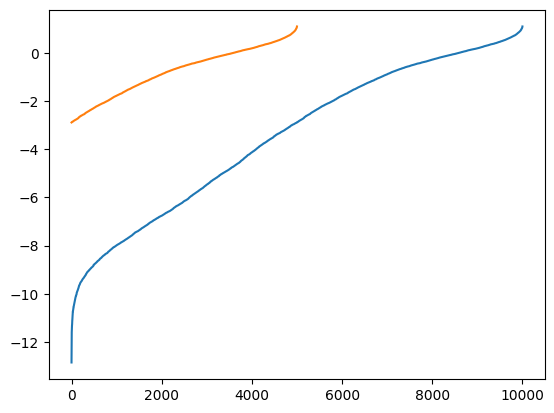

In [21]:
%matplotlib inline

entropy = tent.softmax_entropy(outputs)
entropy = torch.log2(entropy)
entropy_sorted, entropy_sorted_index = entropy.sort()
plt.plot(entropy_sorted.numpy())

high_index = entropy_sorted_index[5000:]
low_index = entropy_sorted_index[:5000]
high_values = entropy[high_index]
low_values = entropy[low_index]
plt.plot(high_values.numpy())



### Correct samples, Wrong samples entropy histogram visualize

                 0
count  6650.000000
mean     -4.490294
std       3.051585
min     -12.851542
25%      -7.051769
50%      -4.654666
75%      -1.754229
max       1.014241
                 0
count  3350.000000
mean     -1.380729
std       2.067541
min     -10.295473
25%      -2.323650
50%      -0.614420
75%       0.114202
max       1.095908


(array([  3.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,   2.,   2.,
          2.,   2.,   3.,   2.,   2.,   1.,   4.,   3.,   2.,   2.,   5.,
          5.,   4.,   2.,   7.,   5.,   6.,   9.,   8.,  10.,   4.,   8.,
         11.,  13.,   9.,  11.,   6.,   8.,   9.,  13.,  12.,  11.,  13.,
         18.,  14.,  20.,  12.,  16.,  19.,  12.,  12.,  17.,  26.,  24.,
         15.,  25.,  19.,  25.,  24.,  27.,  29.,  27.,  28.,  42.,  32.,
         30.,  27.,  39.,  37.,  34.,  45.,  45.,  31.,  50.,  55.,  49.,
         52.,  57.,  69.,  50.,  71.,  63.,  76.,  91.,  93., 114., 124.,
        131., 157., 165., 170., 151., 150., 126.,  96.,  82.,  61.,  33.,
         20.]),
 array([-10.2954731 , -10.18155956, -10.06764507,  -9.95373154,
         -9.839818  ,  -9.72590446,  -9.61198997,  -9.49807644,
         -9.3841629 ,  -9.27024841,  -9.15633488,  -9.04242134,
         -8.9285078 ,  -8.81459332,  -8.70067978,  -8.58676624,
         -8.47285175,  -8.35893822,  -8.24502468,  -8.13111115

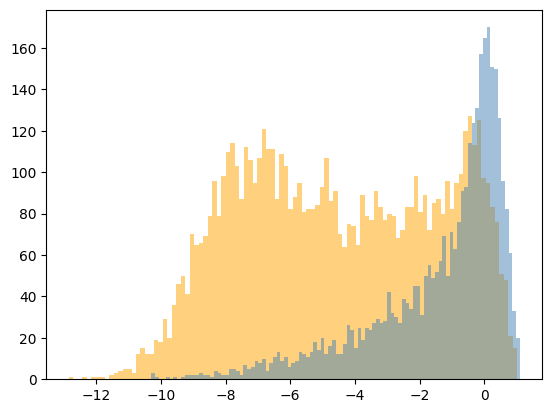

In [22]:
import pandas as pd

data_dir = "/gallery_tate/wonjae.roh/cifar10c"
labels_path = data_dir + '/labels.npy'
labels = np.load(labels_path)
# labels는 10000 sample, 5 severity에 대해 10000개의 같은 label이 5번 반복되는 형태이므로 잘라준다
labels = labels[:10000]

predicted = outputs.argmax(axis=1).numpy()

correct = predicted==labels
wrong = ~correct
entropy_numpy = entropy.numpy()

correct_entropy = entropy_numpy[correct]
wrong_entropy = entropy_numpy[wrong]

correct_describe = pd.DataFrame(correct_entropy)
print(correct_describe.describe())
wrong_describe = pd.DataFrame(wrong_entropy)
print(wrong_describe.describe())

plt.hist(correct_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='orange', edgecolor='none')
plt.hist(wrong_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='steelblue', edgecolor='none')

threshold : -2.8889
low_error : 13.48
high_error : 53.51
total_error : 33.50


(array([505., 374., 517., 702., 603., 447., 531., 400., 490., 431.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 [<matplotlib.patches.Polygon at 0x7f4fc348c820>])

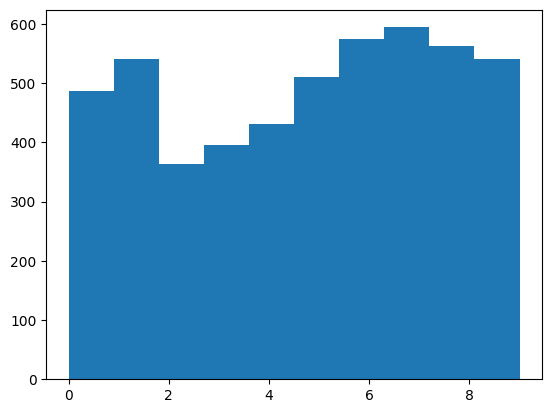

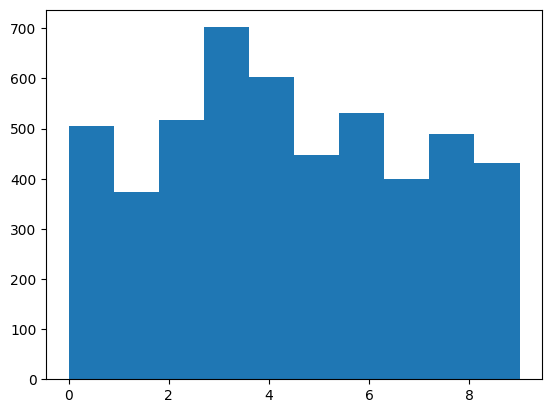

In [36]:
threshold = entropy_sorted[5000].item()
print(f'threshold : {threshold:.4f}') 

correct_high = np.sum(correct_describe > threshold)
correct_low = np.sum(correct_describe < threshold)
wrong_high = np.sum(wrong_describe > threshold)
wrong_low = np.sum(wrong_describe < threshold)

low_error = 100-float(correct_low * 100 / (correct_low + wrong_low))
high_error = 100-float(correct_high * 100 / (correct_high + wrong_high))
total_error = (low_error + high_error) / 2
                       
print(f'low_error : {low_error:.2f}')
print(f'high_error : {high_error:.2f}') 
print(f'total_error : {total_error:.2f}') 

low_outputs=outputs[low_index]
high_outputs=outputs_total[high_index]

plt.figure(0)
plt.hist(low_outputs.argmax(1), bins=10, density=False, histtype='stepfilled', edgecolor='none')
plt.figure(1)
plt.hist(high_outputs.argmax(1), bins=10, density=False, histtype='stepfilled', edgecolor='none')

### Dataloader (low_entropy, high_entropy, all)

Text(0.5, 1.0, 'high entropy gt label histogram')

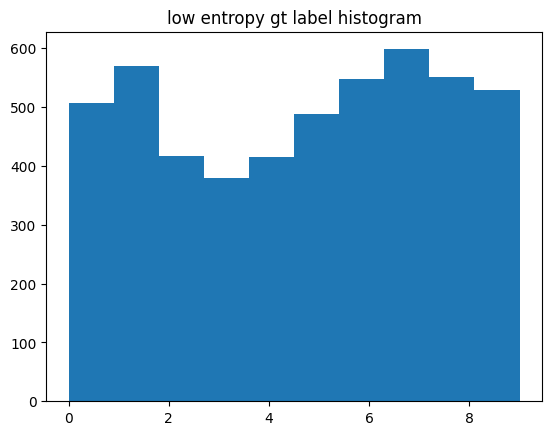

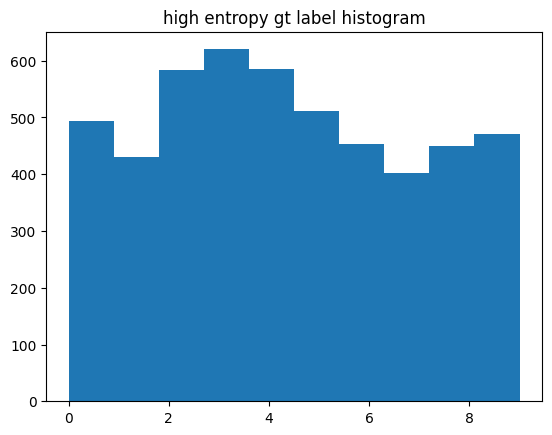

In [24]:
def get_subset(x, y, indices, shuffle=False):
    """get subset of data from indices
    Args:
    x: data
    y: labels
    indices: indices to get subset
    Returns:
    subset of data and labels
    """
    x_sub = x[indices]
    y_sub = y[indices]

    if shuffle:
        rand_idx = np.random.permutation(np.arange(len(x_sub)))
        x_sub, y_sub = x_sub[rand_idx], y_sub[rand_idx]

    return x_sub, y_sub
        
x_low, y_low = get_subset(x_test, y_test, low_index, shuffle=True)
x_high, y_high = get_subset(x_test, y_test, high_index, shuffle=True)   

plt.figure(0)
plt.hist(y_low.cpu(), bins=10, density=False, histtype='stepfilled', edgecolor='none')
plt.title('low entropy gt label histogram')
plt.figure(1)
plt.hist(y_high.cpu(), bins=10, density=False, histtype='stepfilled', edgecolor='none')
plt.title('high entropy gt label histogram')

In [25]:
x_sorted = x_test[entropy_sorted_index]
y_sorted = y_test[entropy_sorted_index]

### adaptation with suitable dataset (all)

In [26]:
def vis_entropy_histogram(outputs, labels):
    entropy = tent.softmax_entropy(outputs)
    entropy = torch.log2(entropy)
    entropy_numpy = entropy.numpy()
    labels = labels.cpu().numpy()

    predicted = outputs.argmax(axis=1).numpy()

    correct = predicted==labels
    wrong = ~correct

    correct_entropy = entropy_numpy[correct]
    wrong_entropy = entropy_numpy[wrong]


    correct_describe = pd.DataFrame(correct_entropy)
    print(correct_describe.describe())
    wrong_describe = pd.DataFrame(wrong_entropy)
    print(wrong_describe.describe())

    plt.hist(correct_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='orange', edgecolor='none')
    plt.hist(wrong_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='steelblue', edgecolor='none')

In [27]:
if cfg.MODEL.ADAPTATION == "tent":
    logger.info("test-time adaptation: TENT")
    model = setup_tent(base_model)
elif cfg.MODEL.ADAPTATION == "source":
    logger.info("test-time adaptation: SOURCE")
    model = setup_source(base_model)
elif cfg.MODEL.ADAPTATION == "pl":
    logger.info("test-time adaptation: PL")
    model = setup_pl(base_model)

In [37]:
model.reset()

# check if it only prints desirable updating parameters
check_freeze(model.model)
 

bn1.weight
bn1.bias
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.shortcut.1.weight
layer2.0.shortcut.1.bias
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.shortcut.1.weight
layer3.0.shortcut.1.bias
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.shortcut.1.weight
layer4.0.shortcut.1.bias
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.bn2.weight
layer4.1.bn2.bias


low_error : 15.52
high_error : 42.86
total_error : 29.19
94s


(array([1029.,  944.,  345., 1450., 1226.,  846., 1202.,  896., 1214.,
         848.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 [<matplotlib.patches.Polygon at 0x7f4fc372c6d0>])

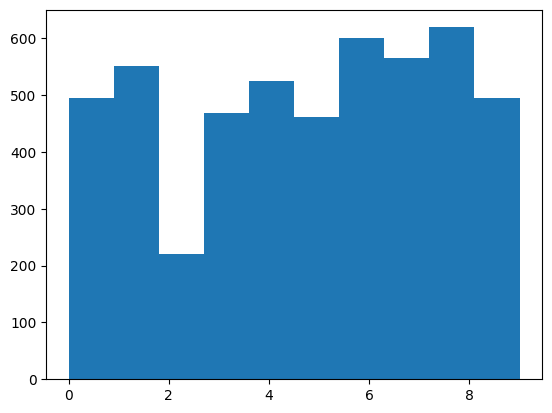

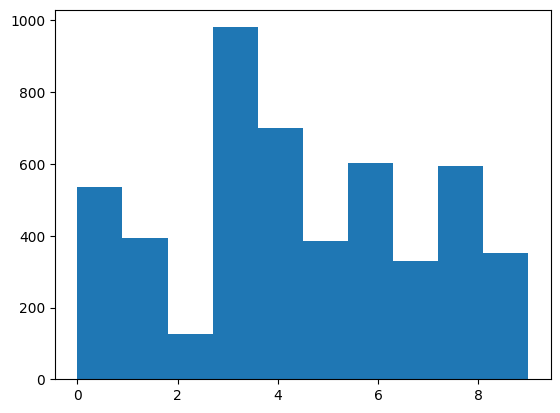

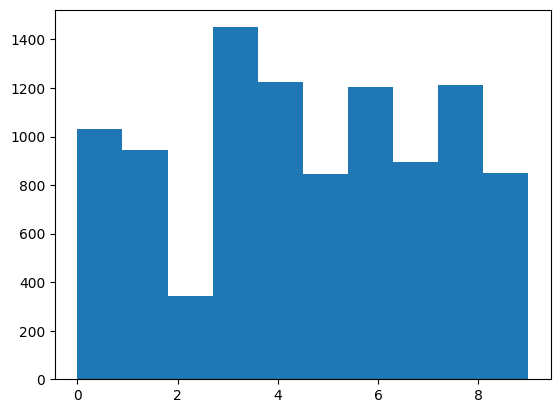

In [38]:
# adapt on all entropy samples

#TEMP0804 train in entropy order, x_sorted instead of x_test
# to flip and get half of high entroyp samples in order, torch.flip(x_sorted, [0])[:5000]

model.set_div_reg(False)

start=time.time()
acc_total, outputs_total = get_stats(model, x_test, y_test, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=5,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False)
end=time.time()

low_outputs=outputs_total[low_index]
low_y=y_test[low_index]
low_acc = (low_outputs.max(1)[1] == low_y.cpu()).float().sum() / low_y.size(0)
print(f'low_error : {(1-low_acc)*100:.2f}')

high_outputs=outputs_total[high_index]
high_y=y_test[high_index]
high_acc = (high_outputs.max(1)[1] == high_y.cpu()).float().sum() / high_y.size(0)
print(f'high_error : {(1-high_acc)*100:.2f}')

print(f'total_error : {(1-acc_total)*100:.2f}') 
print(f'{end - start:.0f}s')

plt.figure(0)
plt.hist(low_outputs.argmax(1), bins=10, density=False, histtype='stepfilled', edgecolor='none')
plt.figure(1)
plt.hist(high_outputs.argmax(1), bins=10, density=False, histtype='stepfilled', edgecolor='none')
plt.figure(2)
plt.hist(outputs_total.argmax(1), bins=10, density=False, histtype='stepfilled', edgecolor='none')

### adaptation with suitable dataset (low)

low_error : 13.28
high_error : 43.88
total_error : 28.58
13s
low_error : 13.36
high_error : 43.48
total_error : 28.42
13s
low_error : 13.24
high_error : 42.44
total_error : 27.84
13s
low_error : 13.34
high_error : 42.74
total_error : 28.04
13s
low_error : 13.24
high_error : 42.82
total_error : 28.03
13s
low_error : 13.28
high_error : 43.08
total_error : 28.18
13s
low_error : 13.28
high_error : 43.62
total_error : 28.45
13s
low_error : 13.38
high_error : 43.46
total_error : 28.42
13s
low_error : 13.34
high_error : 42.98
total_error : 28.16
13s
low_error : 13.32
high_error : 43.32
total_error : 28.32
13s
low_error : 13.28
high_error : 43.00
total_error : 28.14
13s
low_error : 13.32
high_error : 43.52
total_error : 28.42
13s
low_error : 13.26
high_error : 43.18
total_error : 28.22
13s
low_error : 13.34
high_error : 43.20
total_error : 28.27
13s
low_error : 13.24
high_error : 42.38
total_error : 27.81
13s
low_error : 13.22
high_error : 42.96
total_error : 28.09
13s
low_error : 13.34
high_e

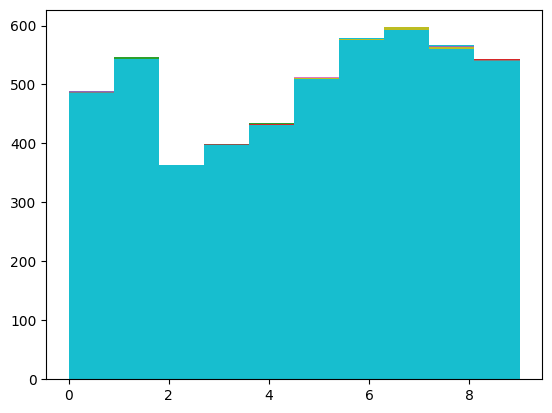

In [13]:
for _ in range(1):
    
    model.reset()
    model.set_div_reg(False)

    #TEMP0804: reproduce가 안돼서 순서에 따라 랜덤인가 싶어서 다시 돌려봄
    x_low, y_low = get_subset(x_test, y_test, low_index, shuffle=True)
    x_high, y_high = get_subset(x_test, y_test, high_index, shuffle=True)

    # check if it only prints desirable updating parameters
    # check_freeze(model.model)

    # adapt on low entropy samples
    start=time.time()
    acc_low, outputs_low = get_stats(model, x_low, y_low, cfg.TEST.BATCH_SIZE, device=device,
                                            iteration=1,
                                            corruption_type=cfg.CORRUPTION.TYPE,
                                            return_raw=True, no_grad=False)
    print(f'low_error : {(1-acc_low)*100:.2f}')  

    # without updating, check on high entropy samples
    acc_high, outputs_high = get_stats(model, x_high, y_high, cfg.TEST.BATCH_SIZE, device=device,
                                            iteration=1,
                                            corruption_type=cfg.CORRUPTION.TYPE,
                                            return_raw=True, no_grad=True) 
    print(f'high_error : {(1-acc_high)*100:.2f}')  
    acc_total = (acc_low + acc_high) / 2
    print(f'total_error : {(1-acc_total)*100:.2f}') 

    end=time.time()
    print(f'{end - start:.0f}s')

    plt.hist(outputs_low.argmax(1), bins=10, density=False, histtype='stepfilled', edgecolor='none')


                 0
count  4333.000000
mean     -6.432445
std       1.982527
min     -12.787315
25%      -7.810975
50%      -6.637636
75%      -5.213866
max       0.560059
                0
count  667.000000
mean    -4.315272
std      2.187034
min    -11.399891
25%     -5.856437
50%     -4.141963
75%     -2.709079
max      0.445667


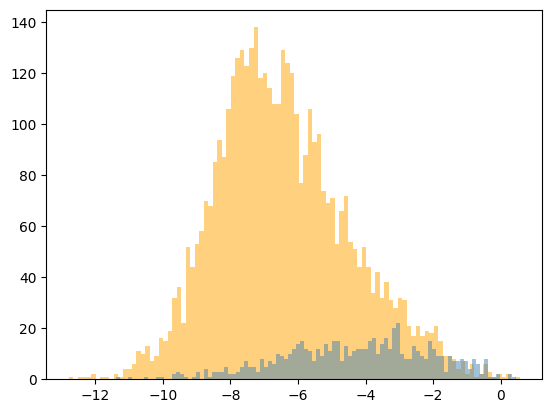

In [15]:
vis_entropy_histogram(outputs_low, y_low)

                 0
count  2834.000000
mean     -3.239376
std       2.705271
min     -12.986950
25%      -5.030849
50%      -2.806942
75%      -0.894905
max       1.031384
                 0
count  2166.000000
mean     -1.396186
std       1.864459
min     -12.505004
25%      -2.301220
50%      -0.734304
75%      -0.067465
max       0.997186


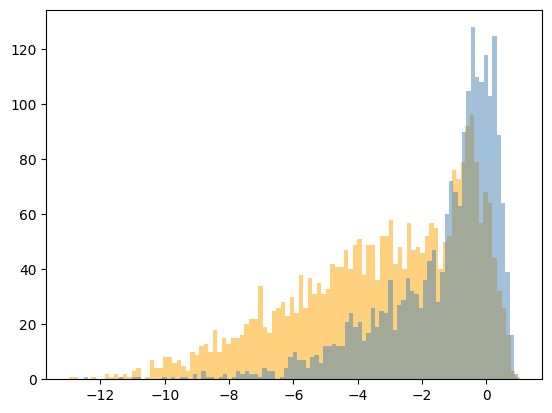

In [16]:
vis_entropy_histogram(outputs_high, y_high)

### adaptation with suitable dataset (high)

low_error : 12.72
high_error : 43.54
total_error : 28.13


(array([543., 385., 394., 580., 451., 562., 615., 456., 612., 402.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 [<matplotlib.patches.Polygon at 0x7fc032472460>])

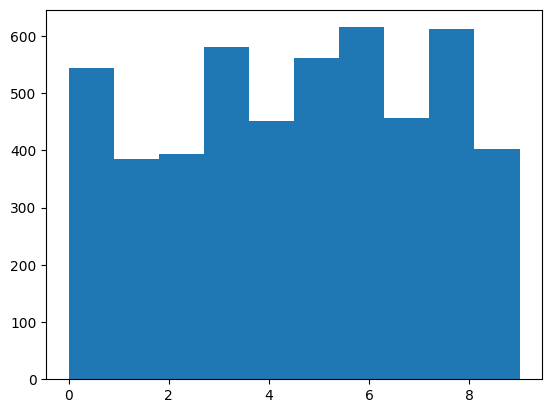

In [17]:
model.reset()

# check if it only prints desirable updating parameters
# check_freeze(model.model)

# adapt on low entropy samples
acc_high, outputs_high = get_stats(model, x_high, y_high, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False)

# without updating, check on high entropy samples
acc_low, outputs_low = get_stats(model, x_low, y_low, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=True) 
print(f'low_error : {(1-acc_low)*100:.2f}')  
print(f'high_error : {(1-acc_high)*100:.2f}')  
acc_total = (acc_low + acc_high) / 2
print(f'total_error : {(1-acc_total)*100:.2f}') 

plt.hist(outputs_high.argmax(1), bins=10, density=False, histtype='stepfilled', edgecolor='none')

                 0
count  4364.000000
mean     -7.407876
std       2.386381
min     -14.259552
25%      -9.046507
50%      -7.886334
75%      -6.272174
max       0.674988
                0
count  636.000000
mean    -3.941856
std      3.041883
min    -12.878219
25%     -6.409679
50%     -3.517770
75%     -1.200285
max      0.798654


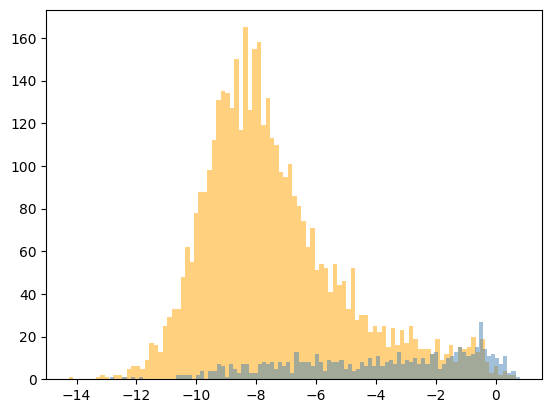

In [18]:
vis_entropy_histogram(outputs_low, y_low)

                 0
count  2823.000000
mean     -3.131048
std       2.687544
min     -12.351473
25%      -4.948227
50%      -2.640620
75%      -0.797487
max       0.935556
                 0
count  2177.000000
mean     -1.372761
std       1.945769
min     -11.706273
25%      -2.205993
50%      -0.671905
75%      -0.029785
max       1.031120


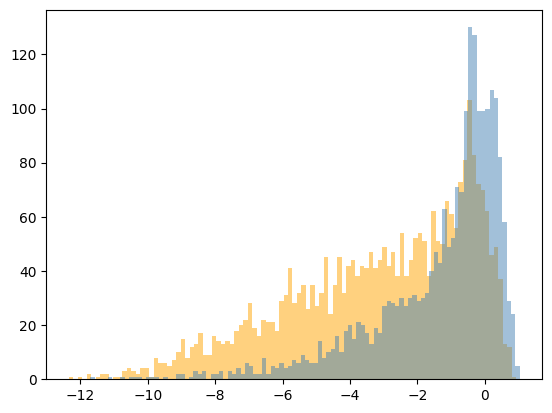

In [19]:
vis_entropy_histogram(outputs_high, y_high)

(array([543., 385., 394., 580., 451., 562., 615., 456., 612., 402.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 [<matplotlib.patches.Polygon at 0x7fc0324b69d0>])

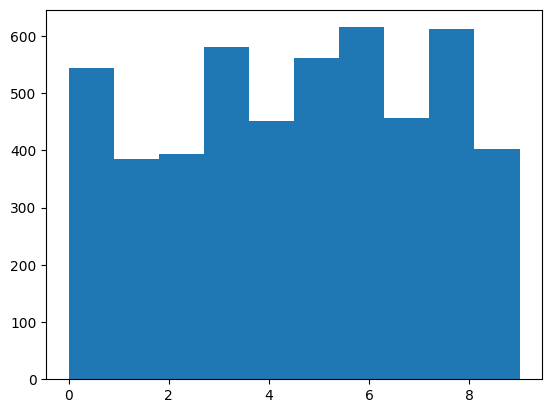

In [20]:
plt.hist(outputs_high.argmax(1), bins=10, density=False, histtype='stepfilled', edgecolor='none')

### adaptation low -> high

low_error : 13.48
high_error : 43.22
total_error : 28.35
51s


(array([486., 543., 374., 415., 428., 484., 575., 589., 561., 545.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 [<matplotlib.patches.Polygon at 0x7fc036e707f0>])

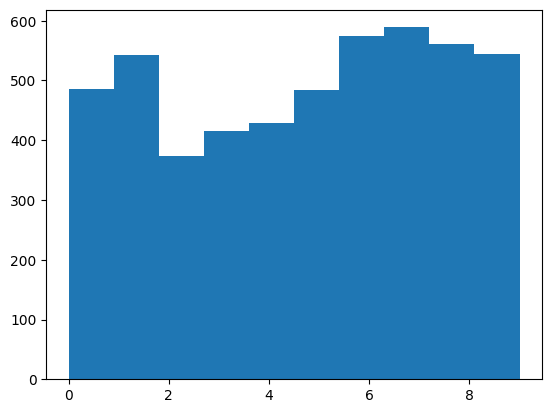

In [21]:
model.reset()
model.set_div_reg(True)

# check if it only prints desirable updating parameters
# check_freeze(model.model)

# adapt on low entropy samples
start=time.time()
acc_low, outputs_low = get_stats(model, x_low, y_low, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=5,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False, gt_label=False)
print(f'low_error : {(1-acc_low)*100:.2f}')  

# without updating, check on high entropy samples

acc_high, outputs_high = get_stats(model, x_high, y_high, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=True, gt_label=False) 
print(f'high_error : {(1-acc_high)*100:.2f}')  
acc_total = (acc_low + acc_high) / 2
print(f'total_error : {(1-acc_total)*100:.2f}') 

end=time.time()
print(f'{end - start:.0f}s')

plt.hist(outputs_low.argmax(1), bins=10, density=False, histtype='stepfilled', edgecolor='none')

high_error : 32.76
9s


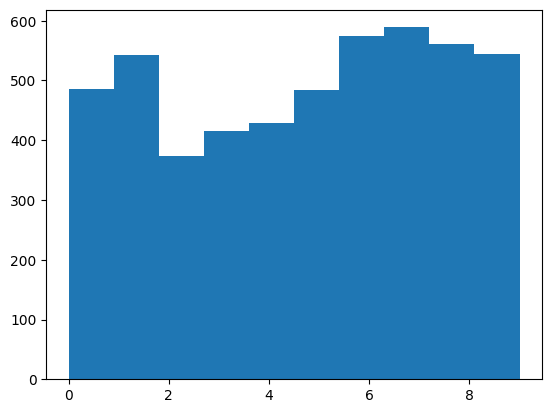

In [22]:
#TEMP0802 to give multiple epochs for high entropy samples with gt label

for _ in range(1):
    
    start=time.time()

    acc_high, outputs_high = get_stats(model, x_high, y_high, cfg.TEST.BATCH_SIZE, device=device,
                                            iteration=1,
                                            corruption_type=cfg.CORRUPTION.TYPE,
                                            return_raw=True, no_grad=False, gt_label=True) 
    print(f'high_error : {(1-acc_high)*100:.2f}')  

    # 34 -> 22.7 -> 19.5 -> 17.8 ... generalization이라는 개념이 없는 상황이므로 0까지도 갈 것

    end=time.time()
    print(f'{end - start:.0f}s')

    plt.hist(outputs_low.argmax(1), bins=10, density=False, histtype='stepfilled', edgecolor='none')

                 0
count  4326.000000
mean     -8.183151
std       2.420081
min     -17.328091
25%      -9.834798
50%      -8.217320
75%      -6.388000
max       0.197650
                0
count  674.000000
mean    -5.990693
std      2.350374
min    -14.850142
25%     -7.065742
50%     -5.522732
75%     -4.354343
max     -0.469786


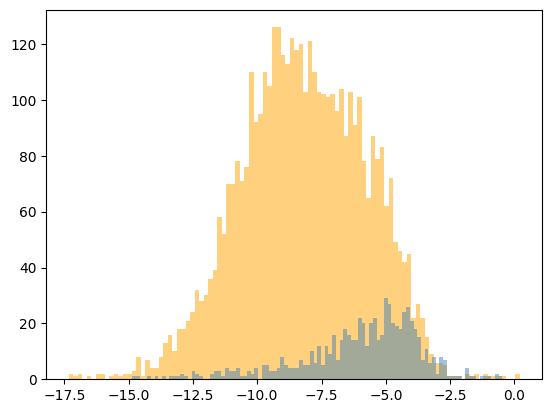

In [23]:
vis_entropy_histogram(outputs_low, y_low)

                 0
count  3362.000000
mean     -5.525350
std       4.012383
min     -20.043823
25%      -8.667797
50%      -5.160079
75%      -1.925398
max       0.758608
                 0
count  1638.000000
mean     -2.138453
std       2.743928
min     -16.160805
25%      -3.125431
50%      -1.115845
75%      -0.319758
max       0.788790


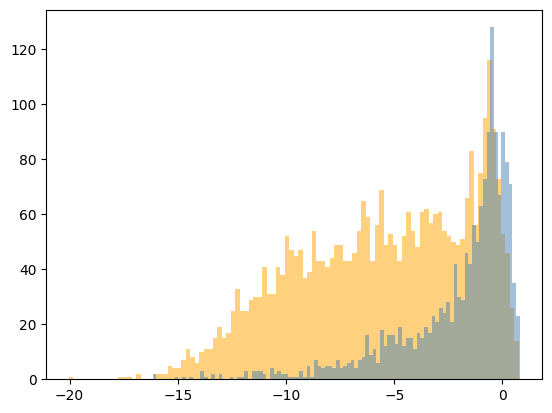

In [24]:
vis_entropy_histogram(outputs_high, y_high)